## Dataset
In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):


The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column card).

In [100]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

## Preparation
- Create the target variable by mapping **yes** to 1 and **no** to 0.
- Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use **train_test_split** funciton for that with **random_state=1**.

In [65]:
df = pd.read_csv('AER_credit_card_data.csv')
df_copy = df.copy()

In [80]:
df_copy.head().T

,0,1,2,3,4
card,1,1,1,1,1
reports,0,0,0,0,0
age,37.66667,33.25,33.66667,30.5,32.16667
income,4.52,2.42,4.5,2.54,9.7867
share,0.03327,0.005217,0.004156,0.065214,0.067051
expenditure,124.9833,9.854167,15.0,137.8692,546.5033
owner,yes,no,yes,no,yes
selfemp,no,no,no,no,no
dependents,3,3,4,0,2
months,54,34,58,25,64


In [67]:
#replace Yes/No with 1 or 0
df_copy['card'] = df_copy['card'].replace({'no':0, 'yes':1 })
df_copy.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [68]:
#check for null values
df_copy.isnull().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

In [69]:
#Splitting the datset
df_full_train, df_test = train_test_split(df_copy, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=.25, random_state=1)

In [70]:
# Processing the dataset
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_test['card']
del df_val['card']


## Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- reports
- dependents
- active
- share

### Answer: share

In [78]:
numerical = ['reports', 'share', 'dependents', 'active']

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])

    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print(f'{c} {auc:.3f}') 

reports 0.717
share 0.989
dependents 0.533
active 0.604


## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [81]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)


# train validation dataset

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

### Answer: .995

In [82]:
roc_auc_score(y_val, y_pred)

0.995171242063847

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8
### Answer: 0.3

In [83]:
def compute_precision_recall(y_val, y_pred):

    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)


    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t ) 


        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn  ))

    columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [84]:
df_scores = compute_precision_recall(y_val, y_pred)
df_scores[::10]

,thresholds,tp,fp,fn,tn
0,0.0,211,53,0,0
10,0.1,210,17,1,36
20,0.2,207,5,4,48
30,0.3,205,5,6,48
40,0.4,205,1,6,52
50,0.5,204,1,7,52
60,0.6,204,1,7,52
70,0.7,204,1,7,52
80,0.8,204,1,7,52
90,0.9,204,0,7,53


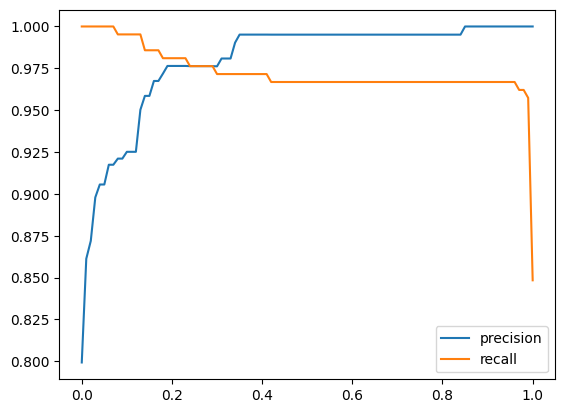

In [87]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.thresholds, df_scores['precision'], label='precision')
plt.plot(df_scores.thresholds, df_scores['recall'], label='recall')
plt.legend()


## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7
### Answer: 0.4

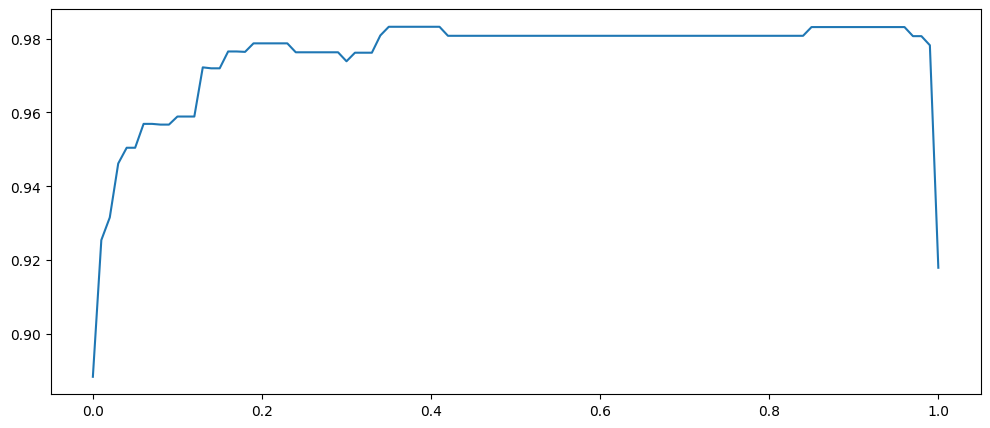

In [98]:
df_scores['f1_score'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

plt.figure(figsize=(12,5))

plt.plot(df_scores.thresholds, df_scores.f1_score)
plt.show()

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

### Answer: 0.003

In [117]:
def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

def train(df_train, y_train, C):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model



In [107]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [110]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv,model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
print('%.3f += %.3f' % (np.mean(scores), np.std(scores)))

0.996 += 0.003


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

### Answer: 1

In [118]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv,model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('%s %.3f += %.3f' % (C, np.mean(scores), np.std(scores)))
    

0.01 0.992 += 0.006
0.1 0.995 += 0.004
1 0.996 += 0.003
10 0.996 += 0.003
